# Setup


In [1]:
%uv pip install ase matcalc[matgl]

Note: you may need to restart the kernel to use updated packages.


Using Python 3.13.12 environment at: c:\Users\asros\miniconda3\envs\cms
Audited 2 packages in 84ms


# Demonstration


In this demonstration, we will identify a transition state using ASE to showcase the NEB method. We will also carry out a vibrational mode analysis to confirm the identity of the transition state.

In this example, we will be looking at the structure of bulk silicon with a vacancy in it and modeling the diffusion of an Si atom into the vacancy.


Here is the setup. We start with bulk silicon, which you can get from any crystal structure database, the Materials Project, or within ASE. We will make a 3x3x3 supercell.


In [2]:
from ase.build import bulk

cell_size = (3, 3, 3)
bulk_crystal = bulk("Si") * cell_size

For good measure, let's make sure to relax the bulk crystal structure, including the unit cell and positions. We will be using the same machine learning potential we have used before since it generally works well. Again, the choice of calculator is not the focal point yet and can be swapped out without having to change the rest of the code.


In [3]:
from matcalc import load_fp

potential_name = "TensorNet-MatPES-r2SCAN-v2025.1-PES"

In [4]:
from ase.optimize import BFGS
from ase.filters import FrechetCellFilter

bulk_crystal.calc = load_fp(potential_name)
opt = BFGS(FrechetCellFilter(bulk_crystal))
opt.run(fmax=0.01)

c:\Users\asros\miniconda3\envs\cms\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


      Step     Time          Energy          fmax
BFGS:    0 20:47:58     -463.165527        0.075693
BFGS:    1 20:47:58     -463.165863        0.075100


c:\Users\asros\miniconda3\envs\cms\Lib\site-packages\scipy\_lib\_util.py:1181: RuntimeWarning: logm result may be inaccurate, approximate err = 5.10067820469786e-13
  return f(*arrays, *other_args, **kwargs)


BFGS:    2 20:47:58     -463.181427        0.000437


np.True_

From here, we are going to introduce a vacancy, which means one of the silicon atoms in the crystal structure will be removed. We will remove the 0th index. This is a defect.


In [5]:
initial = bulk_crystal.copy()
vacancy_coords = bulk_crystal[0].position.copy()  # we will need to save this for later
del initial[0]

Now let's take a look at what we have made. If you rotate the crystal structure, you should see there is one atom missing.


In [6]:
from ase.visualize import view

view(initial)

<Popen: returncode: None args: ['c:\\Users\\asros\\miniconda3\\envs\\cms\\py...>

We are going to model the diffusion of one of the Si atoms into the vacancy. So, our final state will move one of the atoms into the vacancy position, which we will do here.


In [7]:
# Final state: a neighboring atom hops into the vacancy
final = initial.copy()
final[0].position = vacancy_coords

Let's compare the initial and final state. There must be a transition state between these two configurations.


In [8]:
view([initial, final])

<Popen: returncode: None args: ['c:\\Users\\asros\\miniconda3\\envs\\cms\\py...>

Let's start by making sure the initial and final state are at local minima in the potential energy surface by carrying out a geometry optimization. We will keep the unit cell fixed here because we are considering diffusion into a single vacancy in a large semi-infinite crystal, which in reality would not alter the lattice of the material.


In [9]:
for atoms in (initial, final):
    atoms.calc = load_fp(potential_name)
    opt = BFGS(atoms)
    opt.run(fmax=0.01)

      Step     Time          Energy          fmax
BFGS:    0 20:47:59     -452.185730        0.319014
BFGS:    1 20:47:59     -452.204681        0.257944
BFGS:    2 20:47:59     -452.253204        0.323865
BFGS:    3 20:48:00     -452.262329        0.327104
BFGS:    4 20:48:00     -452.344910        0.264357
BFGS:    5 20:48:00     -452.370209        0.177423
BFGS:    6 20:48:00     -452.388428        0.134601
BFGS:    7 20:48:01     -452.397858        0.124163
BFGS:    8 20:48:01     -452.404205        0.070147
BFGS:    9 20:48:01     -452.406097        0.047188
BFGS:   10 20:48:01     -452.406738        0.049054
BFGS:   11 20:48:02     -452.407104        0.037330
BFGS:   12 20:48:02     -452.407501        0.015863
BFGS:   13 20:48:02     -452.407623        0.007139
      Step     Time          Energy          fmax
BFGS:    0 20:48:03     -452.185822        0.318855
BFGS:    1 20:48:03     -452.204651        0.257830
BFGS:    2 20:48:03     -452.253204        0.323912
BFGS:    3 20:48

Great. Now we need to construct images for our NEB. We do this by linearly interpolating between the initial and final state. We will make 5 intermediates images, plus the end points that we have already optimized.


In [10]:
from ase.mep import NEB

n_intermediate_images = 5
images = [initial] + [initial.copy() for _ in range(n_intermediate_images)] + [final]
neb = NEB(images, method="improvedtangent", climb=True)
neb.interpolate()

It's always good practice to view the images before running an NEB calculation. Let's do that and make sure it doesn't look horrible.


In [11]:
view(images)

<Popen: returncode: None args: ['c:\\Users\\asros\\miniconda3\\envs\\cms\\py...>

Looks reasonable enough. Let's make sure all the intermediate images have a calculator.


In [ ]:
for image in images[1:-1]:
    image.calc = load_fp(potential_name)

And now let's run our NEB.


In [ ]:
opt = BFGS(neb)
opt.run(fmax=0.01)

      Step     Time          Energy          fmax
BFGS:    0 20:46:07     -451.895752        0.794845
BFGS:    1 20:46:08     -451.938263        0.677983
BFGS:    2 20:46:10     -452.064728        0.318345
BFGS:    3 20:46:11     -452.077911        0.296930
BFGS:    4 20:46:12     -452.111328        0.136539
BFGS:    5 20:46:14     -452.116241        0.113135
BFGS:    6 20:46:15     -452.119720        0.107755
BFGS:    7 20:46:16     -452.122925        0.082388
BFGS:    8 20:46:18     -452.126617        0.074856
BFGS:    9 20:46:19     -452.128357        0.061053
BFGS:   10 20:46:21     -452.129639        0.055640
BFGS:   11 20:46:22     -452.131104        0.049551
BFGS:   12 20:46:24     -452.132782        0.040925
BFGS:   13 20:46:26     -452.133911        0.031734
BFGS:   14 20:46:28     -452.134369        0.035593
BFGS:   15 20:46:29     -452.134766        0.037629
BFGS:   16 20:46:30     -452.135162        0.032475
BFGS:   17 20:46:32     -452.135376        0.019894
BFGS:   18 20:

np.True_

Time to visualize our trajectory.


In [ ]:
view(images)

<Popen: returncode: None args: ['c:\\Users\\asros\\miniconda3\\envs\\cms\\py...>

To make sure things look good, let's inspect the MEP identified by the NEB calculation. It should only have one local maximum.


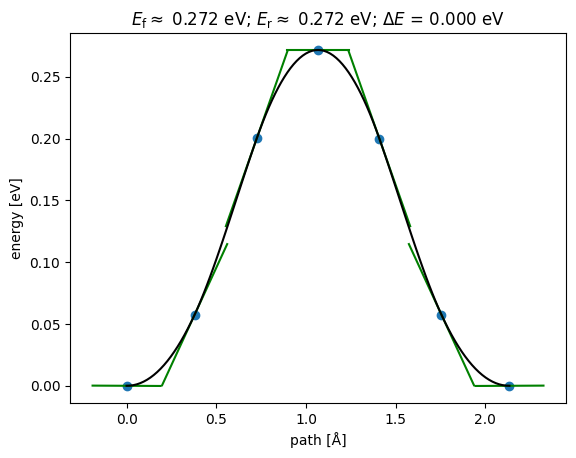

In [ ]:
from ase.mep import NEBTools

fig = NEBTools(images).plot_band()

Looks good! Now as a final sanity check, let's run a vibrational frequency calculation to ensure there is only one imaginary mode.


First, we need to identify the transition state. That's the one with the highest energy.


In [ ]:
import numpy as np

ts_index = np.argmax([img.get_potential_energy() for img in images])
ts = images[ts_index]

Then we run a vibrational frequency calculation. In solids, it is more typical to run a phonon calculation, but we will get to that later in the course. For now, a standard vibrational frequency calculation is fine.


In [ ]:
from ase.vibrations import Vibrations

vib = Vibrations(ts)
vib.clear()  # start fresh
vib.run()  # run vibrational analysis
vib.summary()  # print out summary

Great! There is only one notable imaginary mode. The other modes near 0 are simply numerical noise and can be ignored.


Sanity check! There should be 3N modes. Let's confirm.


In [ ]:
print(f"We have {len(atoms)} atoms, so 3N = {3 * len(atoms)} modes are expected.")
print(f"We have {len(vib.get_frequencies())} modes calculated.")

Let's visualize the imaginary mode and make sure it corresponds to the reaction pathway.


In [ ]:
vib.write_mode(0)

In [ ]:
!ase gui vib.0.traj

Looks good!


Questions to explore:

- How does changing the bulk structure (e.g. the element) alter the diffusion barrier?
- How does changing the unit cell size influence the predicted barrier? This is a parameter that should be converged. Too large and it will be too expensive, but too small and finite size effects may play a role.
- How does the choice of optimizer influence the rate of convergence?
